#Demo de TF-Agents para jugar al Ta-Te-Ti usando primero Q-Learning y luego una red DQN

 Basado en los tutoriales de Tensor Flow: https://www.tensorflow.org/agents/tutorials/2_environments_tutorial

In [1]:
#@title Instalar Paquete de TF-Agents Stable
# usar esta versión para evitar errores
# recomendada en https://github.com/tensorflow/agents
# Use keras-2
!export TF_USE_LEGACY_KERAS=1
!pip install tf-agents[reverb]
# Use this tag get the matching examples and colabs.
!git clone https://github.com/tensorflow/agents.git
!cd agents
print("TF-Agentes instalado.")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 624.4/624.4 kB 7.8 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.7/13.7 MB 19.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.4/6.4 MB 25.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 475.2/475.2 MB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 45.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.4/48.4 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 32.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 35.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 31.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 44.7 MB/s eta 0:00:00
   ━━━

In [2]:
#@title Cargar Librerías

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import abc
import tensorflow as tf
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import random
from random import randint
import pandas as pd


import reverb
from tf_agents.environments import py_environment
from tf_agents.environments import tf_py_environment
from tf_agents.environments import utils
from tf_agents.specs import array_spec
from tf_agents.policies import random_tf_policy
from tf_agents.trajectories import time_step as ts

from tf_agents.agents.dqn import dqn_agent
from tf_agents.agents import CategoricalDqnAgent
from tf_agents.networks import q_network, categorical_q_network
from tf_agents.utils import common

from tf_agents.replay_buffers import tf_uniform_replay_buffer
from tf_agents.trajectories import trajectory

from tf_agents.networks import sequential
from tf_agents.specs import tensor_spec
from tf_agents.replay_buffers import reverb_replay_buffer
from tf_agents.replay_buffers import reverb_utils
from tf_agents.drivers import py_driver
from tf_agents.policies import py_tf_eager_policy

tf.compat.v1.enable_v2_behavior()

print("Librerías cargadas.")
print("(nota: ignorar el error que tira por diferencias de versiones)")

Librerías cargadas.
(nota: ignorar el error que tira por diferencias de versiones)


## Clases sobre el Problema a resolver

In [3]:
#@title Definir Juego Ta-Te-Ti (copia de AlphaZero)

# define el tablero del juego
class Board():

    # list of all 8 directions on the board, as (x,y) offsets
    __directions = [(1,1),(1,0),(1,-1),(0,-1),(-1,-1),(-1,0),(-1,1),(0,1)]

    def __init__(self, n=3):
        "Set up initial board configuration."

        self.n = n
        # Create the empty board array.
        self.pieces = [None]*self.n
        for i in range(self.n):
            self.pieces[i] = [0]*self.n

    # add [][] indexer syntax to the Board
    def __getitem__(self, index):
        return self.pieces[index]

    def get_legal_moves(self, color):
        """Returns all the legal moves for the given color.
        (1 for white, -1 for black)
        @param color not used and came from previous version.
        """
        moves = set()  # stores the legal moves.

        # Get all the empty squares (color==0)
        for y in range(self.n):
            for x in range(self.n):
                if self[x][y]==0:
                    newmove = (x,y)
                    moves.add(newmove)
        return list(moves)

    def has_legal_moves(self):
        for y in range(self.n):
            for x in range(self.n):
                if self[x][y]==0:
                    return True
        return False

    def is_win(self, color):
        """Check whether the given player has collected a triplet in any direction;
        @param color (1=white,-1=black)
        """
        win = self.n
        # check y-strips
        for y in range(self.n):
            count = 0
            for x in range(self.n):
                if self[x][y]==color:
                    count += 1
            if count==win:
                return True
        # check x-strips
        for x in range(self.n):
            count = 0
            for y in range(self.n):
                if self[x][y]==color:
                    count += 1
            if count==win:
                return True
        # check two diagonal strips
        count = 0
        for d in range(self.n):
            if self[d][d]==color:
                count += 1
        if count==win:
            return True
        count = 0
        for d in range(self.n):
            if self[d][self.n-d-1]==color:
                count += 1
        if count==win:
            return True

        return False

    def execute_move(self, move, color):
        """Perform the given move on the board;
        color gives the color pf the piece to play (1=white,-1=black)
        """

        (x,y) = move

        # Add the piece to the empty square.
        assert self[x][y] == 0
        self[x][y] = color

# define el juego a aprender
class ProblemGame:
    def __init__(self, n=3):
        self.n = n

    def getInitBoard(self):
        # return initial board (numpy board)
        b = Board(self.n)
        return np.array(b.pieces)

    def getBoardSize(self):
        # (a,b) tuple
        return (self.n, self.n)

    def getActionSize(self):
        # return number of actions
        return self.n*self.n + 1

    def getNextState(self, board, player, action):
        # if player takes action on board, return next (board,player)
        # action must be a valid move
        if action == self.n*self.n:
            return (board, -player)
        b = Board(self.n)
        b.pieces = np.copy(board)
        move = (int(action/self.n), action%self.n)
        b.execute_move(move, player)
        return (b.pieces, -player)

    def getValidMoves(self, board, player):
        # return a fixed size binary vector
        valids = [0]*self.getActionSize()
        b = Board(self.n)
        b.pieces = np.copy(board)
        legalMoves =  b.get_legal_moves(player)
        if len(legalMoves)==0:
            valids[-1]=1
            return np.array(valids)
        for x, y in legalMoves:
            valids[self.n*x+y]=1
        return np.array(valids)

    def getGameEnded(self, board, player):
        # return 0 if not ended, 1 if player 1 won, -1 if player 1 lost
        b = Board(self.n)
        b.pieces = np.copy(board)
        if b.is_win(player):
            return 1
        if b.is_win(-player):
            return -1
        if b.has_legal_moves():
            return 0
        # draw has a very little value
        return 1e-4

    def getCanonicalForm(self, board, player):
        # return state if player==1, else return -state if player==-1
        return player*board

    def getSymmetries(self, board, pi):
        # Si el tablero del juego es simétrico
        # este método permite rotarlo (mirror, rotational)
        # para generar más ejemplos
        # asociado a las mismas probabilidades (genera más ejemplos para aprender)
        assert(len(pi) == self.n**2+1)  # 1 for pass
        pi_board = np.reshape(pi[:-1], (self.n, self.n))
        l = []

        for i in range(1, 5):
            for j in [True, False]:
                newB = np.rot90(board, i)
                newPi = np.rot90(pi_board, i)
                if j:
                    newB = np.fliplr(newB)
                    newPi = np.fliplr(newPi)
                l += [(newB, list(newPi.ravel()) + [pi[-1]])]
        return l

    def stringRepresentation(self, board):
        # 8x8 numpy array (canonical board)
        return board.tobytes()
        #### tostring()

    @staticmethod
    def display(board):
        n = board.shape[0]
        sangria = "     "
        print(sangria, "   ", end="")
        for y in range(n):
            print(y, "", end="")
        print("")
        print(sangria, "  ", end="")
        for _ in range(n):
            print("-", end="-")
        print("--")
        for y in range(n):
            print(sangria, y, "|",end="")    # print the row #
            for x in range(n):
                piece = board[y][x]    # get the piece to print
                if piece == -1: print("X ",end="")
                elif piece == 1: print("O ",end="")
                else:
                    if x==n:
                        print("-",end="")
                    else:
                        print("- ",end="")
            print("|")
        print(sangria, "  ", end="")
        for _ in range(n):
            print("-", end="-")
        print("--")

# define jugador que juega al azar
class RandomPlayer():
    def __init__(self, game):
        self.game = game

    def play(self, board):
        a = np.random.randint(self.game.getActionSize())
        valids = self.game.getValidMoves(board, 1)
        while valids[a]!=1:
            a = np.random.randint(self.game.getActionSize())
        return a


# define jugador humano para jugar
class HumanPlayer():

    def __init__(self, game):
        self.game = game

    def play(self, board):
        # display(board)
        valid = self.game.getValidMoves(board, 1)
        while True:
            print("Indique la coordenada donde desea jugar: ")
            a = input()
            x, y = -1, -1
            if a.find(' ') > 0:
              x, y = [int(x) for x in a.split(' ')]
            else:
              if a[0].isnumeric() and a[1].isnumeric():
                x = int(a[0])
                y = int(a[1])
            a = self.game.n * x + y if x!= -1 else self.game.n ** 2
            if (a>=0) and (a<len(valid)) and valid[a]:
                break
            else:
                print('Coordenada inválida')

        return a

print("Clases del Juego definidas")

Clases del Juego definidas


In [4]:
#@title Definir Entorno del Problema

# función auxiliar para saber si se define función de torneo
preparadoHacerCompetir = False

# funciones y variables auxiliares
def formateaAccion(action, n=3):
  return (int(action/n), action%n)

# indica si observation es un vector o matriz
USAR_OBS_VECTOR = False

# utiliza internamente la clase ProblemGame definida anteriomente
# al momento de crear se determina el tipo de contrincante
class ProblemGameEnv(py_environment.PyEnvironment):

  def __init__(self, jugContrincante=None):
    # inicializa el juego
    self._juego = ProblemGame()
    # inicializa si corresponde el contrincante
    # (usado para usar agentes no TF-Agents)
    if jugContrincante is None:
      self._jugadorContrincante = None
    else:
      self._jugadorContrincante = jugContrincante(self._juego)
    # inicializa variables auxiliares
    cantPosiblesAcciones = self._juego.getActionSize() - 2
    auxiTTamTablero = self._juego.getBoardSize()
    # determina formas
    self._action_spec = array_spec.BoundedArraySpec(
        shape=(), dtype=np.int32, minimum=0, maximum=cantPosiblesAcciones, name='action')
    if USAR_OBS_VECTOR:
      # devuelve como vector
      cantReprsTablero = auxiTTamTablero[0] * auxiTTamTablero[1]
      self._observation_spec = array_spec.BoundedArraySpec(
          shape=(cantReprsTablero,), dtype=np.int32, minimum=-1, maximum=1, name='observation')
    else:
      # devuelve como matriz
      self._observation_spec = array_spec.BoundedArraySpec(
          shape=(auxiTTamTablero[0], auxiTTamTablero[1],), dtype=np.int32, minimum=-1, maximum=1, name='observation')
    # inicializa el tablero
    self._reset()

  def action_spec(self):
    # devuelve la forma de las acciones
    return self._action_spec

  def observation_spec(self):
    # devuelve la forma de las observaciones
    return self._observation_spec

  def formateaJugador(self, idJugador):
    if (idJugador==1):
      return "O"
    else:
      return "X"

  def jugarContrincante(self):
    # si puede jugar
    if self._jugadorContrincante is None:
      return False
    if self._juego.getGameEnded(self._board, -1) == 0:
      # determina la acción y la aplica
      action = self._jugadorContrincante.play(self._juego.getCanonicalForm(self._board, -1))
      self._board, sgtIdJugador = self._juego.getNextState(self._board, -1, action)
      self._textoRender = self._textoRender + "\t" + self.formateaJugador(-1) + " juega pos " + str(formateaAccion(action)) + "\n"
    return True

  def devolverEstadoTablero(self, idJug=1):
    # devuelve estado de tablero
    # (siempre el policy es jugador 1)
    # como matriz
    auxTablero = self._juego.getCanonicalForm(self._board, idJug)
    if USAR_OBS_VECTOR:
      # como vector
      auxTablero = np.array(auxTablero).flatten()
    return auxTablero

  def _reset(self):
    # resetea el entorno
    self._board = self._juego.getInitBoard()
    self._rewardVal = 0
    # determina si empieza contrincante
    self._textoRender = ""
    if self._jugadorContrincante is not None:
      if randint(0,9) < 5 :
        self._textoRender = "\tcomienza " + self.formateaJugador(-1) + "\n"
        self.jugarContrincante()
    # continua con el otro jugador
    self._idJugador = 1
    return ts.restart( np.array(self.devolverEstadoTablero(1), dtype=np.int32) )

  def _step(self, action):
    # ejecuta la acción sobre el entorno

    if self._juego.getGameEnded(self._board, self._idJugador) != 0:
      # si el entorno está finalizado, lo resetea
      return self.reset()

    # determina id del jugador actual
    idJug = self._idJugador

    # Controla que la acción es válida y la aplica
    validAccs = self._juego.getValidMoves(self._board, idJug)
    if (action>=0) and (action<len(validAccs)) and (validAccs[action] == 1):
        # Aplica la acción
        self._board, sgtJugador = self._juego.getNextState(self._board, idJug, action)
        penaliza = 0.0
        self._textoRender = self._textoRender + "\t" + self.formateaJugador(idJug) + " juega pos " + str(formateaAccion(action)) + "\n"
    else:
        # Si no es válida, la ignora pero la penaliza
        # (si tira error, corta la jugada)
        penaliza = -10.0
        self._textoRender = self._textoRender + "\t" + self.formateaJugador(idJug) + " intenta acción inválida con pos " + str(formateaAccion(action)) + "\n"
    ##  raise ValueError('Acción ' + str(action) + ' inválida ' + str(validAccs) + '.')

    # si juega el contrincante
    if self.jugarContrincante():
      # mantiene id 1 del jugador (contrincante siempre es -1)
      self._idJugador = 1
    else:
      # alterna el id del jugador
      self._idJugador = idJug * (-1)

    # determina el estado del tablero (para devolver)
    estadoTablero = self.devolverEstadoTablero(self._idJugador)

    # analiza si finaliza (siempre de jugador 1)
    terminaJuego = self._juego.getGameEnded(self._board, 1)
    if terminaJuego != 0:
      # si finaliza
      # determina el reward
      # (positivo para jugador 1 y negativo para jugador -1)
      self._rewardVal = terminaJuego * 100
      if terminaJuego < 0:
        self._rewardVal = self._rewardVal - penaliza
      else:
        self._rewardVal = self._rewardVal + penaliza
      return ts.termination(
              np.array(estadoTablero, dtype=np.int32),
              reward=self._rewardVal)
    else:
      if penaliza < 0:
        # si no aplico una acción válida, devuelve el valor que penaliza
        auxRewardVal = penaliza
      else:
        # si aplico una acción válida, devuelve la cantidad de fichas que coloco
        auxRewardVal = np.count_nonzero(estadoTablero == 1) * 10.0
      # si no finaliza
      return ts.transition(
              np.array(estadoTablero, dtype=np.int32),
              reward=auxRewardVal, discount=0.9)


  def render(self, mode = 'human'):
    # muestra información sobre el entorno
    if mode == 'human':
      # (en este caso el tablero actual y jugadas)
      if (self._textoRender != ""):
        # muestra texto con jugadas
        print(self._textoRender)
        self._textoRender = ""
        # muestra el tablero
        self._juego.display(self._board)
    elif mode == 'humanFinal':
      # (en este caso el tablero final y reward)
        # muestra el tablero
        self._juego.display(self._board)
    elif mode == 'humanReward':
      if self._rewardVal != 0:
        #print('\n = Recompensa final = ', round(self._rewardVal,3))
        if self._rewardVal >= 75:
          print("    -> GANA " + self.formateaJugador(1) + " y PIERDE " + self.formateaJugador(-1) + "")
        elif self._rewardVal <= -75:
          print("    -> GANA " + self.formateaJugador(-1) + " y PIERDE " + self.formateaJugador(1) + "")
        else:
          print("    -> EMPATAN " + self.formateaJugador(1) + " y " + self.formateaJugador(-1) + "")
    # devuelve estado del tablero
    return self._board

print("Entorno del Problema definido.")

# Definir entornos de entrenamiento y evaluación
train_py_env = ProblemGameEnv(RandomPlayer)
evalRP_py_env = ProblemGameEnv(RandomPlayer)
eval2P_py_env = ProblemGameEnv()

# Definir wrapper para convertir en entornos TF
train_env = tf_py_environment.TFPyEnvironment(train_py_env)
evalRP_env = tf_py_environment.TFPyEnvironment(evalRP_py_env)
eval2P_env = tf_py_environment.TFPyEnvironment(eval2P_py_env)
eval_env = evalRP_env

# define política al azar independiente del Agente
random_policy = random_tf_policy.RandomTFPolicy(train_env.time_step_spec(),
                                                train_env.action_spec())

print("Entornos de entrenamiento y prueba definidos. ")

# definir simulador para probar el entorno jugando dos jugadores
def SimularEntorno(env, policyList, descAgList, titulo, num_episodes=1, mostrarDetalle=True):
    # controla parámetros
    if num_episodes <=0:
      num_episodes = 1
    if (policyList is None) or (len(policyList) < 1) or (len(policyList) > 2):
      raise ValueError('Se deben indicar 1 o 2 políticas para simular.')
      return -1
    if (descAgList is None):
      descAgList = ["Agente 1", "Agente 2"]
    elif len(policyList) < 1:
      descAgList.append("Otro Agente")
    # inicializa acumulador auxiliar
    cantGanados = [0.0, 0.0]
    # muestra títulos
    print("\n** ", titulo, " **")
    print("    (" + descAgList[0] + " usa 'O', " + descAgList[1] + " usa 'X') ")
    for i in range(num_episodes):
      if num_episodes > 1:
        print("\n> Episodio " + str(i+1) + ": ")
      # muesta estado inicial
      time_step = env.reset()
      ##print(time_step)
      if mostrarDetalle:
        print(" Ini: ")
        env.pyenv.render("human")
        print(" ")
      j = 1
      corteXcant = False
      while not time_step.is_last():
        for policy in policyList:
          # la política determina la acción a realizar
          action_step = policy.action(time_step)
          ##print( time_step , "\n", policy, "\n",  action_step )
          time_step = env.step(action_step.action)
          if time_step.is_last():
            # se termino
            break
        # recupera la observación y muestra el nuevo estado
        if mostrarDetalle:
          print(" #" + str(j) + ":", end="")
          # muestra estado del tablero
          env.pyenv.render("human")
          print(" ")
        j = j + 1
        if j >= 101:
          print("Se finaliza por hacer más de " + str(j-1) + "!!!")
          corteXcant = True
          break

      # muestra estado final
      ob = time_step.observation.numpy()[0]
      r = time_step.reward.numpy()[0]
      if mostrarDetalle:
        print(" Fin: ")
      else:
        # muestra tablero final solamente
        env.pyenv.render("humanFinal")
      # muestra reward
      env.pyenv.render("humanReward")
      if corteXcant:
        # se corta por cantidad de ciclos
        # es un empate pero ambos pierden
        cantGanados[0] -= 0.5
        cantGanados[1] -= 0.5
      elif r >= 75:
        # gana 1
        cantGanados[0] += 1.0
      elif r <= -75:
        # gana -1
        cantGanados[1] += 1.0
      else:
        # empatan
        cantGanados[0] += 0.5
        cantGanados[1] += 0.5
    if num_episodes > 1:
      print("\n= Total Partidos Ganados: ")
      maxGan = np.max(cantGanados)
      fichaJuega = "O"
      for agDesc, ganCant in zip(descAgList, cantGanados):
        print("\t " + agDesc +" con '" + fichaJuega + "': " + str(round(ganCant,1)) + " " + ("*" if ganCant==maxGan else "") )
        fichaJuega = "X"
      return cantGanados
    else:
      return cantGanados

print("Simulador del entorno definido.")

# Probar el entorno definido con Política Aleatoria (opcional)
Probar_Entorno = True #@param {type:"boolean"}
MostarDetalleJugada = True #@param {type:"boolean"}

if Probar_Entorno:
  SimularEntorno(evalRP_env, [random_policy], ["AzarPolicy", "AzarRP"], "Probando el entorno del problema al azar (con una policiy)", 1, MostarDetalleJugada)
  print("\n")
  SimularEntorno(eval2P_env, [random_policy, random_policy], ["AzarPolicy1", "AzarPolicy2"], "Probando el entorno del problema al azar (con dos policy)", 1, MostarDetalleJugada)


Entorno del Problema definido.
Entornos de entrenamiento y prueba definidos. 
Simulador del entorno definido.

**  Probando el entorno del problema al azar (con una policiy)  **
    (AzarPolicy usa 'O', AzarRP usa 'X') 
 Ini: 
 
 #1:	O juega pos (2, 2)
	X juega pos (1, 1)

         0 1 2 
        --------
      0 |- - - |
      1 |- X - |
      2 |- - O |
        --------
 
 #2:	O juega pos (1, 2)
	X juega pos (2, 1)

         0 1 2 
        --------
      0 |- - - |
      1 |- X O |
      2 |- X O |
        --------
 
 #3:	O juega pos (0, 1)
	X juega pos (0, 2)

         0 1 2 
        --------
      0 |- O X |
      1 |- X O |
      2 |- X O |
        --------
 
 #4:	O juega pos (1, 0)
	X juega pos (0, 0)

         0 1 2 
        --------
      0 |X O X |
      1 |O X O |
      2 |- X O |
        --------
 
 #5:	O juega pos (2, 0)

         0 1 2 
        --------
      0 |X O X |
      1 |O X O |
      2 |O X O |
        --------
 
 Fin: 
    -> EMPATAN O y X



**  Probando el ento

##Q-Learning

In [5]:
#@title Define clase auxiliar Policy para Q-Learning

## funciones auxiliares basadas en:
##  https://rubikscode.net/2019/06/24/introduction-to-q-learning-with-python-and-open-ai-gym/

from tf_agents.policies.fixed_policy import FixedPolicy
from tf_agents.trajectories import policy_step
from tf_agents.utils import nest_utils
from tf_agents.specs import tensor_spec
from tf_agents.typing import types
from typing import Optional, Text

## funciones auxiliares para manejar TS->Obs
## (se puede definir otras si es necesario)

# devuelve el primer valor de OBS
# como número de estado
def obtenerEstadoDeObs(obs):
  return obs[0]

# devuelve valor unico en base a vector OBS
# para determinar fila de estado
def generarNroEstadoVector(obs):
  ntarget = np.array(obs).flatten()
  valorTotal = 0
  for i in range(1, len(ntarget)):
    if ntarget[i] == -1:
      valorTotal = valorTotal + 2**i
    elif ntarget[i] == 1:
      valorTotal = valorTotal + 3**i
  return valorTotal

# devuelve la cantidad de estados máxima
# que se pueden generar usando un ejemplo
# del vector de OBS
def calcMaxNroEstadoVector(ejemploObs):
  ntarget = np.array(ejemploObs).flatten()
  cant = len(ntarget)
  return ( 3**cant + 2**cant + 1 )


# Clase Policy Wrapper para Q-Learning
# (se hereda de FixedPolicy porque es una simple para tener como base)
class QL_TF_Policy(FixedPolicy):

  def __init__(self,
               posiblesEstadosList,
               posiblesAccionesList,
               time_step_spec: ts.TimeStep,
               action_spec: types.NestedTensorSpec,
               funcDevuelveNroEstado = obtenerEstadoDeObs,
               policy_info: types.NestedTensorSpec = (),
               info_spec: types.NestedTensorSpec = (),
               name: Optional[Text] = None):

      # llama al padre
      super(FixedPolicy, self).__init__(time_step_spec, action_spec, clip=False,
                                      info_spec=info_spec,
                                      name=name,
                                      emit_log_probability=False)
      # guarda valores auxiliares
      self._policy_info = policy_info
      self._time_step_spec = tensor_spec.from_spec(time_step_spec)
      self._action_spec = tensor_spec.from_spec(action_spec)
      self._funcDevuelveNroEstado = funcDevuelveNroEstado
      # inicializa parametros de matriz
      if (posiblesEstadosList is None) or (len(posiblesEstadosList)<2):
       raise ValueError('No se ha definida la lista de posibles estdos!' )
      self._posiblesEstadosList = posiblesEstadosList
      self._cantEstados = len(posiblesEstadosList)
      if (posiblesAccionesList is None) or (len(posiblesAccionesList)<2):
       raise ValueError('No se ha definida la lista de posibles acciones!' )
      self._posiblesAccionesList = posiblesAccionesList
      self._cantAcciones = len(posiblesAccionesList)
      self.ResetQ()

  # funcion auxiliar para inicializar la matriz
  def ResetQ(self):
      self._Qtable = np.zeros([self._cantEstados, self._cantAcciones])
      self._QtableEntrenada = False

  # función auxiliar de entrenamiento
  def TrainQ(self, env, train_policy, alpha = 0.1, gamma = 0.6, epsilon = 0.1, cant_ciclos_entrenamiento = 100000, log_cada_ciclos = 1000, mostrarDetalleAcciones=False):
      ##print(self._Qtable.shape)
      ##print(self._usarOBSVector)
      # ejecuta el entrenamiento
      for step in range(1, cant_ciclos_entrenamiento+1):
          # Resetea el enviroment
          time_step = env.reset()
          ob = time_step.observation.numpy()[0]
          state = self._funcDevuelveNroEstado(ob)
          secuenciaAcciones = ""
          j = 1
          # Simula
          while not time_step.is_last():
              # Considera lo aprendido o toma al azar depende de azar y epsilon
              if random.uniform(0, 1) < epsilon:
                  # toma de Matriz-Q
                  accionAplicar = np.argmax( self._Qtable[state] )
              else:
                  # toma al azar
                  action_step = train_policy.action( time_step )
                  accionAplicar = action_step.action.numpy()[0]
              if j > 1:
                secuenciaAcciones = secuenciaAcciones + " + "
              secuenciaAcciones = secuenciaAcciones + self._posiblesAccionesList[ accionAplicar ]
              j = j + 1
              # Aplica la Accion
              time_step = env.step( accionAplicar )
              ob = time_step.observation.numpy()[0]
              next_state = self._funcDevuelveNroEstado(ob)
              r = time_step.reward.numpy()[0]
              # Recalcula Q
              q_value = self._Qtable[state, accionAplicar]
              max_value = np.max(self._Qtable[next_state])
              new_q_value = (1 - alpha) * q_value + alpha * (r + gamma * max_value)
              # Actualiza Matriz-Q
              self._Qtable[state, accionAplicar] = new_q_value
              state = next_state
          # muestra estado
          if log_cada_ciclos > 0:
            if (step == 1) or (step % log_cada_ciclos == 0):
              if mostrarDetalleAcciones:
                print('step = {0}: Recompensa = {1} - Acciones({2}) = {3} '.format(step, r, (j-1), secuenciaAcciones))
              else:
                print('step = {0}: Recompensa = {1} - Acciones({2}) '.format(step, r, (j-1)))
      # Devuelve Matriz-Q
      self._QtableEntrenada = True
      return self._Qtable

  # obtiene Q-Table como DataFrame
  def getQ_DF(self):
        cm = self._Qtable
        cmtx = pd.DataFrame(
            cm,
            index=self._posiblesEstadosList,
            columns=self._posiblesAccionesList
          )
        return cmtx

  # graba Q-Table como CSV
  def saveQ(self, fileName):
        # obtiene data frame de matriz Q
        df = self.getQ_DF()
        # graba matriz Q como CSV
        df.to_csv(fileName, index=True)
        return

  # recupera Q-Table de  CSV
  def loadQ(self, fileName):
        # lee matriz Q de CSV
        df = pd.read_csv(fileName)
        # carga elementos en memoria
          # saca nombre de estados
        self._posiblesEstadosList = list(df.pop(df.columns[0]))
          # acciones
        self._posiblesAccionesList = list(df.columns.tolist())
          # borra el primer elemento de titulo
        ##self._posiblesAccionesList = np.delete(self._posiblesAccionesList, 0, axis=0)
         # matriz Q
        self._Qtable = list(df.to_numpy())
        # re-inicializa las cantidades
        self._cantEstados = len(self._posiblesEstadosList)
        self._cantAcciones = len(self._posiblesAccionesList)
        self._QtableEntrenada = True
        # muestra resultados
        self.MostrarQ("Matriz-Q recuperada:")
        return

  # función auxiliar para mostrar matri Q
  def MostrarQ(self, titulo="Matriz-Q entrenada:"):
        # muestra Q table
        cmtx = self.getQ_DF()
        print('\n ' + titulo + ' ')
        # agrega para poder mostrar la matrix de confusión completa
        pd.options.display.max_rows = 100
        pd.options.display.max_columns = 100
        print(cmtx)
        print("\n")
        return

  # devuelve la accion que se debe aplicar usando la matrix Q entrenada
  def _action(self, time_step, policy_state, seed):
      # determina la accion a realizar
      # obtiene estado actual
      ob = time_step.observation.numpy()[0]
      state = self._funcDevuelveNroEstado(ob)
      # toma de Matriz-Q
      accionAplicar = np.argmax( self._Qtable[state] )
      # formatea el valor a devolver usando la action_spec y time_step_spec
      def convert(action, spec):
        return tf.convert_to_tensor(value=action, dtype=spec.dtype)
      self._action_value = tf.nest.map_structure(convert, accionAplicar,
                                                  self._action_spec)
      outer_shape = nest_utils.get_outer_shape(time_step, self._time_step_spec)
      action = tf.nest.map_structure(lambda t: common.replicate(t, outer_shape),
                                   self._action_value)
      # devuelve la accion
      return policy_step.PolicyStep(action, policy_state, self._policy_info)


print("Clase QL_TF_Policy creada.")

Clase QL_TF_Policy creada.


In [6]:
#@title Entrenar con algoritmo Q-Learning

# parámetros
entrenar_QL = True #@param {type:"boolean"}
alpha = 0.1 #@param {type:"number"}
gamma = 0.8 #@param {type:"number"}
epsilon = 0.4 #@param {type:"number"}
cant_ciclos_entrenamiento_finalizar = 10000 #@param {type:"integer"}
mostar_recompensa_cada = 500  #@param {type:"integer"}
if alpha <= 0.0:
   alpha = 0.001
if gamma <= 0.0:
    gamma = 0.001
if epsilon <= 0.0:
   epsilon = 0.001
if cant_ciclos_entrenamiento_finalizar <= 10:
   cant_ciclos_entrenamiento_finalizar = 10
if mostar_recompensa_cada < 1:
  mostar_recompensa_cada = 1


# valores auxiliares para TaTeTi
auxjuego = ProblemGame()
cantPosiblesAcciones = auxjuego.getActionSize() - 1
posiblesAccionesDescrip = [str(formateaAccion(x)) for x in range(0, cantPosiblesAcciones)]
ejObs = train_env.reset().observation
cantPosiblesEstados = calcMaxNroEstadoVector(ejObs)
posiblesEstadosDescrip = ['E{:}'.format(x) for x in range(0, cantPosiblesEstados+1)]

# instancia política de Q Learning
ql_policy = QL_TF_Policy(posiblesEstadosList = posiblesEstadosDescrip,
                         posiblesAccionesList = posiblesAccionesDescrip,
                         time_step_spec = train_env.time_step_spec(),
                         action_spec = train_env.action_spec(),
                         funcDevuelveNroEstado = generarNroEstadoVector
                         )

if entrenar_QL:
  # hace el entrenamiento
  print("** Comienza el Entrenamiento:\n")
  ql_policy.TrainQ(env = train_env,
                   train_policy = random_policy,
                   alpha = alpha, gamma = gamma, epsilon = epsilon,
                   cant_ciclos_entrenamiento = cant_ciclos_entrenamiento_finalizar,
                   log_cada_ciclos = mostar_recompensa_cada,
                   mostrarDetalleAcciones = False)
  print("\n** Entrenamiento Finalizado **")
  # muestra matriz
  ql_policy.MostrarQ()
else:
  print("No se ejecuta entrenamiento de Agente Q-Learning.")

** Comienza el Entrenamiento:

step = 1: Recompensa = -90.0 - Acciones(5) 
step = 500: Recompensa = 100.0 - Acciones(4) 
step = 1000: Recompensa = -90.0 - Acciones(3) 
step = 1500: Recompensa = -100.0 - Acciones(4) 
step = 2000: Recompensa = -90.0 - Acciones(4) 
step = 2500: Recompensa = -100.0 - Acciones(3) 
step = 3000: Recompensa = -90.0 - Acciones(4) 
step = 3500: Recompensa = -90.0 - Acciones(5) 
step = 4000: Recompensa = -90.0 - Acciones(4) 
step = 4500: Recompensa = -100.0 - Acciones(4) 
step = 5000: Recompensa = -100.0 - Acciones(3) 
step = 5500: Recompensa = -90.0 - Acciones(3) 
step = 6000: Recompensa = 100.0 - Acciones(4) 
step = 6500: Recompensa = -100.0 - Acciones(4) 
step = 7000: Recompensa = -90.0 - Acciones(5) 
step = 7500: Recompensa = -90.0 - Acciones(3) 
step = 8000: Recompensa = 100.0 - Acciones(3) 
step = 8500: Recompensa = -100.0 - Acciones(4) 
step = 9000: Recompensa = -90.0 - Acciones(4) 
step = 9500: Recompensa = 0.009999999776482582 - Acciones(6) 
step = 10000

In [7]:
#@title Probar Q-Learning Entrenado contra el Azar
cantidad_probar = 10 # @param {type:"integer"}
MostarDetalleJugada = False #@param {type:"boolean"}

if ql_policy._QtableEntrenada:
  res = SimularEntorno(eval2P_env, [ql_policy, random_policy], ["Q-Learning", "AzarPolicy"], "Probando el Agente Q-Learning entrenado contra azar", cantidad_probar, MostarDetalleJugada)



**  Probando el Agente Q-Learning entrenado contra azar  **
    (Q-Learning usa 'O', AzarPolicy usa 'X') 

> Episodio 1: 
         0 1 2 
        --------
      0 |X O X |
      1 |- X X |
      2 |O O X |
        --------
    -> GANA X y PIERDE O

> Episodio 2: 
         0 1 2 
        --------
      0 |O O O |
      1 |- X X |
      2 |- - - |
        --------
    -> GANA O y PIERDE X

> Episodio 3: 
         0 1 2 
        --------
      0 |- O X |
      1 |- O X |
      2 |- O - |
        --------
    -> GANA O y PIERDE X

> Episodio 4: 
         0 1 2 
        --------
      0 |- O X |
      1 |- O - |
      2 |- O X |
        --------
    -> GANA O y PIERDE X

> Episodio 5: 
         0 1 2 
        --------
      0 |O O O |
      1 |- - - |
      2 |X X - |
        --------
    -> GANA O y PIERDE X

> Episodio 6: 
         0 1 2 
        --------
      0 |O O O |
      1 |X O - |
      2 |O - X |
        --------
    -> GANA O y PIERDE X

> Episodio 7: 
         0 1 2 
        -

##DQN

In [8]:
#@title Definir el Agente tipo DQN
entrenar_DQN = True # @param {type:"boolean"}
DQNpolicy = None

if entrenar_DQN:
  # agente categorical oculto por ahora (problemas en librería)
  tipo_agente = "DQN" #param ["DQN", "DQN Categorico (C51)"]
  learning_rate = 1e-3  # @param {type:"number"}
  cant_neuronas_ocultas = "100, 50, 25" # @param {type:"string"}
  DQNCat_num_atoms = 51  #param {type:"integer"}

  # controla cantidad de atoms para DQN Cat
  if DQNCat_num_atoms <= 1:
    DQNCat_num_atoms = 51

  #define las capas convolutional
  CNN_preprocessing_layers = None

  # Define cantidad de neuronas ocultas para RNA-Q
  hidden_layers = []
  for val in cant_neuronas_ocultas.split(','):
    if  int(val) < 1:
      hidden_layers.append( 10 )
    else:
      hidden_layers.append( int(val) )
  fc_layer_params = tuple(hidden_layers, )
  #print(fc_layer_params)

  if tipo_agente=="DQN":

    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    train_step_counter = tf.Variable(0)

    # Define RNA-Q
    q_net = q_network.QNetwork(
        train_env.observation_spec(),
        train_env.action_spec(),
        fc_layer_params=fc_layer_params)

    # Define el agente de tipo Q
    ag = dqn_agent.DqnAgent(
        train_env.time_step_spec(),
        train_env.action_spec(),
        q_network=q_net,
        optimizer=optimizer,
        td_errors_loss_fn=common.element_wise_squared_loss,
        train_step_counter=train_step_counter)

    ag.initialize()

    print("Agente DQN inicializado. ")

  elif tipo_agente == "DQN Categorico (C51)":

    # Define RNA-Q Categórico
    categorical_q_net = categorical_q_network.CategoricalQNetwork(
        train_env.observation_spec(),
        train_env.action_spec(),
        num_atoms=DQNCat_num_atoms,
        fc_layer_params=fc_layer_params)

    optimizer = tf.compat.v1.train.AdamOptimizer(learning_rate=learning_rate)

    train_step_counter = tf.compat.v2.Variable(0)

    # parámetros especificos (por defecto)
    n_step_update = 2
    gamma = 0.99

    # Define el agente de tipo Q Categórico
    ag = CategoricalDqnAgent(
        train_env.time_step_spec(),
        train_env.action_spec(),
        categorical_q_network=categorical_q_net,
        optimizer=optimizer,
        n_step_update=n_step_update,
        td_errors_loss_fn=common.element_wise_squared_loss,
        gamma=gamma,
        train_step_counter=train_step_counter)

    ag.initialize()

    print("Agente DQN Categorico (C51) inicializado. ")
else:
  print("No se ejecuta entrenamiento de Agente DQN.")

Agente DQN inicializado. 


In [9]:
#@title Métricas para evaluación y Preparar datos para Entrenamiento del Agente DQN

if entrenar_DQN:

  # parámetros
  initial_collect_steps = 100  # @param {type:"integer"}
  collect_steps_per_iteration = 10# @param {type:"integer"}
  replay_buffer_max_length = 100000  # @param {type:"integer"}
  batch_size = 64  # @param {type:"integer"}
  num_eval_episodes = 10  # @param {type:"integer"}

  # Definir Métricas para evaluación para Agente DQN

  #eval_policy = ag.policy
  #collect_policy = ag.collect_policy
  #time_step = train_env.reset()

  # Se usa el promedio de la recompensa (la más común)
  # See also the metrics module for standard implementations of different metrics.
  # https://github.com/tensorflow/agents/tree/master/tf_agents/metrics

  def compute_avg_return(environment, policy, num_episodes=10):
    if num_episodes == 0:
        return 0.0
    total_return = 0.0
    for _ in range(num_episodes):

      time_step = environment.reset()
      episode_return = 0.0

      while not time_step.is_last():
        action_step = policy.action(time_step)
        time_step = environment.step(action_step.action)
        episode_return += time_step.reward
      total_return += episode_return

    avg_return = total_return / num_episodes
    return avg_return.numpy()[0]

  ##compute_avg_return(eval_env, random_policy, num_eval_episodes)

  # Define 'Replay Buffer' para que el agente recuerde las observaciones realizadas

  table_name = 'uniform_table'
  replay_buffer_signature = tensor_spec.from_spec(
        ag.collect_data_spec)
  replay_buffer_signature = tensor_spec.add_outer_dim(
      replay_buffer_signature)

  table = reverb.Table(
      table_name,
      max_size=replay_buffer_max_length,
      sampler=reverb.selectors.Uniform(),
      remover=reverb.selectors.Fifo(),
      rate_limiter=reverb.rate_limiters.MinSize(1),
      signature=replay_buffer_signature)

  reverb_server = reverb.Server([table])

  replay_buffer = reverb_replay_buffer.ReverbReplayBuffer(
      ag.collect_data_spec,
      table_name=table_name,
      sequence_length=2,
      local_server=reverb_server)

  rb_observer = reverb_utils.ReverbAddTrajectoryObserver(
    replay_buffer.py_client,
    table_name,
    sequence_length=2)

  print("\nDatos recolectados.")

  # Dataset generates trajectories with shape [Bx2x...]
  dataset = replay_buffer.as_dataset(
      num_parallel_calls=3,
      sample_batch_size=batch_size,
      num_steps=2).prefetch(3)
  iterator = iter(dataset)

  print("\nDataset creado para datos recolectadso.")

else:
  print("No se ejecuta entrenamiento de Agente DQN.")


Datos recolectados.

Dataset creado para datos recolectadso.


In [10]:
#@title Entrenar al Agente DQN

if entrenar_DQN:

  cant_ciclos_entrenamiento_finalizar = 50000# @param {type:"integer"}
  log_cada_ciclos = 200  # @param {type:"integer"}
  mostar_recompensa_cada = 500  # @param {type:"integer"}
  cant_episodios_evaluacion =  10# @param {type:"integer"}
  minima_recompensa_promedio_finalizar = 100.0 # @param {type:"number"}

  # (Optional) Optimize by wrapping some of the code in a graph using TF function.
  ag.train = common.function(ag.train)

  # Reset the train step.
  ag.train_step_counter.assign(0)

  # Evaluate the agent's policy once before training.
  avg_return = compute_avg_return(eval_env, ag.policy, cant_episodios_evaluacion)
  ar_cicloL = []
  ar_cicloR = []
  ar_returns = []
  ar_loss = []

  # Reset the environment.
  time_step = train_py_env.reset()

  # Create a driver to collect experience.
  collect_driver = py_driver.PyDriver(
      train_py_env,
      py_tf_eager_policy.PyTFEagerPolicy(
        ag.collect_policy, use_tf_function=True),
      [rb_observer],
      max_steps=collect_steps_per_iteration)

  print("\n** Comienza el Entrenamiento **\n")
  for _ in range(cant_ciclos_entrenamiento_finalizar):

    # Collect a few steps and save to the replay buffer.
    time_step, _ = collect_driver.run(time_step)

    # Sample a batch of data from the buffer and update the agent's network.
    experience, unused_info = next(iterator)
    train_loss = ag.train(experience).loss

    step = ag.train_step_counter.numpy()

    if (step == 1) or (step == cant_ciclos_entrenamiento_finalizar) or (step % log_cada_ciclos == 0):
      print('step = {0}: loss = {1:.3f}'.format(step, train_loss))
      ar_cicloL.append( step )
      ar_loss.append( train_loss )

    if (step == 1) or (step == cant_ciclos_entrenamiento_finalizar) or (step % mostar_recompensa_cada == 0):
      avg_return = compute_avg_return(eval_env, ag.policy, cant_episodios_evaluacion)
      ar_cicloR.append( step )
      ar_returns.append( avg_return )
      print('step = {0}: Promedio Recompensa = {1:.1f}'.format(step, avg_return))

      if (avg_return >= minima_recompensa_promedio_finalizar):
        print('** Finaliza en step {0} por buen valor de recompensa promedio: {1:.1f}'.format(step, avg_return))
        break

  DQNpolicy = ag.policy
  print("\n** Entrenamiento Finalizado **\n")
else:
  print("No se ejecuta entrenamiento de Agente DQN.")


** Comienza el Entrenamiento **



Instructions for updating:
back_prop=False is deprecated. Consider using tf.stop_gradient instead.
Instead of:
results = tf.foldr(fn, elems, back_prop=False)
Use:
results = tf.nest.map_structure(tf.stop_gradient, tf.foldr(fn, elems))


step = 1: loss = 2123.686
step = 1: Promedio Recompensa = -74.0
step = 200: loss = 226.001
step = 400: loss = 57.188
step = 500: Promedio Recompensa = -84.0
step = 600: loss = 72.995
step = 800: loss = 117.133
step = 1000: loss = 585.038
step = 1000: Promedio Recompensa = -74.0
step = 1200: loss = 1135.280
step = 1400: loss = 866.296
step = 1500: Promedio Recompensa = 47.0
step = 1600: loss = 706.171
step = 1800: loss = 1145.318
step = 2000: loss = 1592.184
step = 2000: Promedio Recompensa = 24.0
step = 2200: loss = 1260.175
step = 2400: loss = 822.566
step = 2500: Promedio Recompensa = 41.0
step = 2600: loss = 1736.035
step = 2800: loss = 1228.371
step = 3000: loss = 1014.881
step = 3000: Promedio Recompensa = 19.0
step = 3200: loss = 1316.441
step = 3400: loss = 1579.274
step = 3500: Promedio Recompensa = 75.0
step = 3600: loss = 1055.071
step = 3800: loss = 1198.543
step = 4000: loss = 892.158
step = 4000: Promedio Recompensa = 59.0
step = 4200: loss = 1487.552
step = 4400: loss = 1

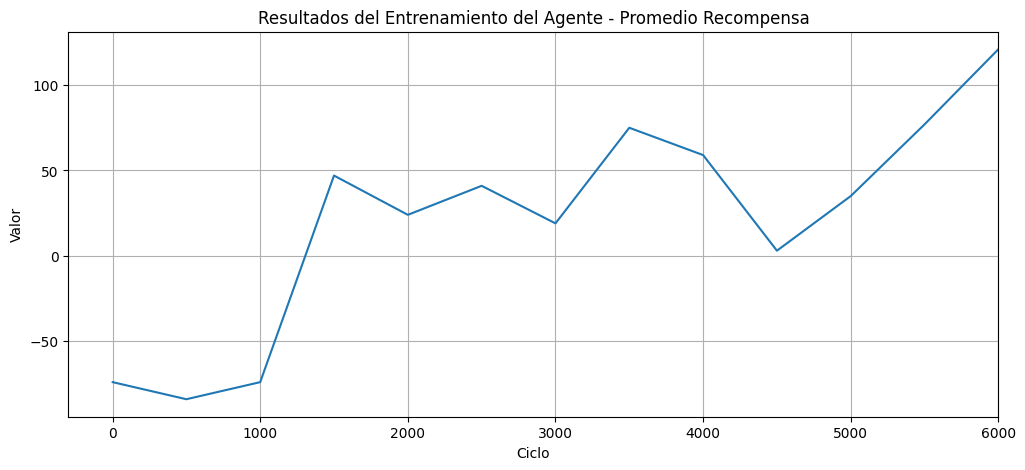

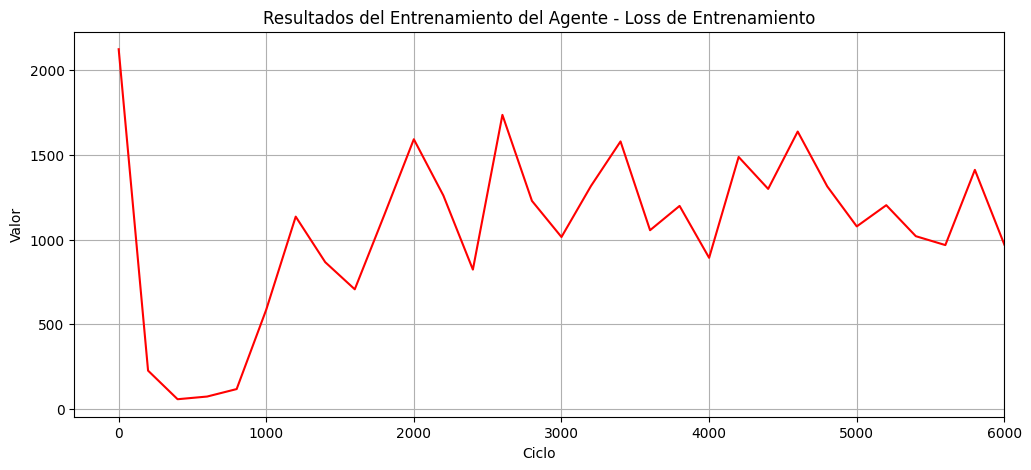

In [11]:
#@title Mostrar Gráficos del Entrenamiento del Agente DQN


if entrenar_DQN:

  plt.figure(figsize=(12,5))
  plt.plot( ar_cicloR, ar_returns)
  plt.title("Resultados del Entrenamiento del Agente - Promedio Recompensa")
  #plt.legend(['Promedio Recompensa', 'Loss de Entrenamiento'], loc='upper right')
  plt.ylabel('Valor')
  plt.xlabel('Ciclo')
  plt.xlim(right=max(ar_cicloR))
  plt.grid(True)
  plt.show()

  plt.figure(figsize=(12,5))
  plt.plot( ar_cicloL, ar_loss, color="red" )
  plt.title("Resultados del Entrenamiento del Agente - Loss de Entrenamiento")
  #plt.legend(['Promedio Recompensa', 'Loss de Entrenamiento'], loc='upper right')
  plt.ylabel('Valor')
  plt.xlabel('Ciclo')
  plt.xlim(right=max(ar_cicloL))
  plt.grid(True)
  plt.show()


In [12]:
#@title Probar el Agente DQN Entrenado contra el Azar
cantidad_probar = 10 # @param {type:"integer"}
MostarDetalleJugada = False #@param {type:"boolean"}

if DQNpolicy is not None:
  SimularEntorno(eval2P_env, [DQNpolicy, random_policy], ["DQN", "AzarPolicy"], "Probando el Agente DQN entrenado contra azar", cantidad_probar, MostarDetalleJugada)



**  Probando el Agente DQN entrenado contra azar  **
    (DQN usa 'O', AzarPolicy usa 'X') 

> Episodio 1: 
         0 1 2 
        --------
      0 |X X O |
      1 |- O - |
      2 |O - O |
        --------
    -> GANA O y PIERDE X

> Episodio 2: 
         0 1 2 
        --------
      0 |- - O |
      1 |- O X |
      2 |O - X |
        --------
    -> GANA O y PIERDE X

> Episodio 3: 
         0 1 2 
        --------
      0 |X O X |
      1 |X O X |
      2 |X X O |
        --------
    -> GANA X y PIERDE O

> Episodio 4: 
         0 1 2 
        --------
      0 |X X O |
      1 |- O - |
      2 |O X O |
        --------
    -> GANA O y PIERDE X

> Episodio 5: 
         0 1 2 
        --------
      0 |O - X |
      1 |- O X |
      2 |O X O |
        --------
    -> GANA O y PIERDE X

> Episodio 6: 
         0 1 2 
        --------
      0 |O X X |
      1 |- O - |
      2 |- - O |
        --------
    -> GANA O y PIERDE X

> Episodio 7: 
         0 1 2 
        --------
      

## Torneo

In [14]:
#@title Cargar o Guardar los Agentes Q-Learning y DQN entrenados

# parámetros
directorio_modelo = '/content/gdrive/MyDrive/IA/demoRL/Modelos' #@param {type:"string"}
nombre_modelo_grabar = "policy-TaTeTi" #@param {type:"string"}
accion_realizar = "Grabar Modelo" #@param ["-", "Cargar Modelo", "Grabar Modelo"]

if accion_realizar != "-":
  import os
  from google.colab import drive
  from tf_agents.policies import TFPolicy, policy_saver
  # determina lugar donde se guarda el modelo
  policy_dir = os.path.join(directorio_modelo, nombre_modelo_grabar)
  qlCSV = policy_dir + "/QM-QLearning.csv"
  # Montar Drive
  drive.mount('/content/gdrive')
if accion_realizar == "Grabar Modelo":
  if (DQNpolicy is not None) and isinstance(DQNpolicy, TFPolicy):
    # guarda la politica del agente DQN entrenado
    tf_policy_saver = policy_saver.PolicySaver(DQNpolicy)
    tf_policy_saver.save(policy_dir)
    print("\nPolítica DQN guardada en ", policy_dir)
  if ql_policy is not None:
    if not os.path.exists(policy_dir):
         os.makedirs(policy_dir)
    ql_policy.saveQ(qlCSV)
    print("\nPolítica Q-Learning guardada en ", qlCSV)
elif accion_realizar == "Cargar Modelo":
  # carga la política del modelo
  DQNpolicy = tf.compat.v2.saved_model.load(policy_dir)
  print("\nPolítica DQN recuperada de ", policy_dir)
  ql_policy.loadQ(qlCSV)
  print("\nPolítica Q-Learning recuperada de ", qlCSV)


Mounted at /content/gdrive


/usr/local/lib/python3.10/dist-packages/tensorflow/python/saved_model/nested_structure_coder.py:458: UserWarning: Encoding a StructuredValue with type tfp.distributions.Deterministic_ACTTypeSpec; loading this StructuredValue will require that this type be imported and registered.
  warnings.warn("Encoding a StructuredValue with type %s; loading this "



Política DQN guardada en  /content/gdrive/MyDrive/IA/demoRL/Modelos/policy-TaTeTi

Política Q-Learning guardada en  /content/gdrive/MyDrive/IA/demoRL/Modelos/policy-TaTeTi/QM-QLearning.csv


In [16]:
#@title Cargar Agente AlphaZero ya entrenado (opcional)
#@markdown (partes de código copiadas de AlphaZero)
# parámetros
directorio_modelo = '/content/gdrive/MyDrive/IA/demoRL/Modelos' #@param {type:"string"}
nombre_modelo_grabar = "AlphaZero-TaTeTi" #@param {type:"string"}
accion_realizar = "Cargar Modelo" #@param ["-", "Cargar Modelo"]

if accion_realizar != "-":

  import math
  from tensorflow.keras.models import load_model

  ## comienzo copiado de AlphaZero

  ### Definir clases para RNA del Agente
  class NNet():
      def __init__(self, game, args):
          # game params
          self.board_x, self.board_y = game.getBoardSize()
          self.action_size = game.getActionSize()
          self.args = args

          if self.args is None:
            self.model = None
          else:
            # Neural Net
            # AlphaZero uses a deep neural network (pi,v)=f(s)
            # which takes the board position "s" as an input
            # and outputs a vector of move probabilities "p=Pr(a|s)" for each action "a",
            # and a scalar value "v" estiamting the expected outcome "z" from position "s",
            # Here it learns these move probabilities and value estimates entirely from self-play,
            # which are then used guide its search.
            self.input_boards = Input(shape=(self.board_x, self.board_y))    # s: batch_size x board_x x board_y

            x_image = Reshape((self.board_x, self.board_y, 1))(self.input_boards)                # batch_size  x board_x x board_y x 1
            h_conv1 = Activation('relu')(BatchNormalization(axis=3)(Conv2D(args.num_channels, 3, padding='same')(x_image)))         # batch_size  x board_x x board_y x num_channels
            h_conv2 = Activation('relu')(BatchNormalization(axis=3)(Conv2D(args.num_channels, 3, padding='same')(h_conv1)))         # batch_size  x board_x x board_y x num_channels
            h_conv3 = Activation('relu')(BatchNormalization(axis=3)(Conv2D(args.num_channels, 3, padding='same')(h_conv2)))        # batch_size  x (board_x) x (board_y) x num_channels
            h_conv4 = Activation('relu')(BatchNormalization(axis=3)(Conv2D(args.num_channels, 3, padding='valid')(h_conv3)))        # batch_size  x (board_x-2) x (board_y-2) x num_channels
            h_conv4_flat = Flatten()(h_conv4)
            s_fc1 = Dropout(args.dropout)(Activation('relu')(BatchNormalization(axis=1)(Dense(1024)(h_conv4_flat))))  # batch_size x 1024
            s_fc2 = Dropout(args.dropout)(Activation('relu')(BatchNormalization(axis=1)(Dense(512)(s_fc1))))          # batch_size x 1024
            # "pi" is the MCTS informed policy vector for the given board,
            self.pi = Dense(self.action_size, activation='softmax', name='pi')(s_fc2)   # batch_size x self.action_size
            # "v" is its value.
            self.v = Dense(1, activation='tanh', name='v')(s_fc2)                    # batch_size x 1

            self.model = Model(inputs=self.input_boards, outputs=[self.pi, self.v])
            self.model.compile(loss=['categorical_crossentropy','mean_squared_error'], optimizer=Adam(args.lr))
            # muestra el modelo creado
            self.model.summary()


  class NNetWrapper():
      def __init__(self, game, args):
          self.nnet = NNet(game, args)
          self.board_x, self.board_y = game.getBoardSize()
          self.action_size = game.getActionSize()
          self.trainHistory = []

      def train(self, examples):
        # nota se hace una pequeña modificación para guardar información para generar gráfico
          """
          examples: list of examples, each example is of form (board, pi, v)
          """
          input_boards, target_pis, target_vs = list(zip(*examples))
          input_boards = np.asarray(input_boards)
          target_pis = np.asarray(target_pis)
          target_vs = np.asarray(target_vs)
          # entrena y guada histórico para el gráfico
          history = self.nnet.model.fit(x = input_boards, y = [target_pis, target_vs], batch_size = args.batch_size, epochs = args.epochs)
          self.trainHistory.append( history )

      def genTrainGraphs(self, infoGraficar='loss', titulo="Gráfico del Entrenamiento"):
        # nota se agrega este método para gráficar resultados del entrenamiento
        plt.figure(figsize=(15,8))
        legs = []
        for i in range(len(self.trainHistory)):
          plt.plot(self.trainHistory[i].history[infoGraficar])
          legs.append( "Iter "+str(i+1))
        plt.title(titulo)
        plt.legend(legs, loc='best')
        plt.ylabel('')
        plt.xlabel('Epoch')
        plt.show()


      def predict(self, board):
          """
          board: np array with board
          Returns:
              pi: a policy vector for the current board- a numpy array of length
                  game.getActionSize
              v: a float in [-1,1] that gives the value of the current board
          """
          # timing
          ##start = time.time()

          # preparing input
          board = board[np.newaxis, :, :]

          # run
          pi, v = self.nnet.model.predict(board, verbose = 0)

          ##print('PREDICTION TIME TAKEN : {0:03f}'.format(time.time()-start))
          ##print("PI ", pi, "--", v)
          return pi[0], v[0]

      def save_checkpoint(self, folder='checkpoint', filename='checkpoint.h5'):
        # nota se hace una pequeña modificación para que funcione corretamente
          filepath = os.path.join(folder, filename)
          if not os.path.exists(folder):
              print("  No existe el directorio de checkpoints! Se crea {}".format(folder))
              os.mkdir(folder)
          #else:
          #    print("Checkpoint Directory exists! ")
          self.nnet.model.save_weights(filepath)
          print("  Checkpoint grabado en '{}'".format(filepath))

      def load_checkpoint(self, folder='checkpoint', filename='checkpoint.h5'):
        # nota se hace una pequeña modificación para que funcione corretamente
          filepath = os.path.join(folder, filename)
          if not os.path.exists(folder):
            print("  No se encuentra un checkpoint en '{}'".format(filepath))
            #  raise("No model in path '{}'".format(filepath))
          else:
            self.nnet.model.load_weights(filepath)
            print("  Checkpoint cargado de '{}'".format(filepath))


      def save_model(self, folder='model', filename='model.h5'):
        # nota nuevo método para guardar todo el modelo
          filepath = os.path.join(folder, filename)
          if not os.path.exists(folder):
              print("  No existe el directorio para guardar el modelo! Se crea {}".format(folder))
              os.mkdir(folder)
          #else:
          #    print("Checkpoint Directory exists! ")
          self.nnet.model.save(filepath)
          print("  Checkpoint grabado en '{}'".format(filepath))

      def load_model(self, folder='model', filename='model.h5'):
        # nota nuevo método para cargar todo el modelo
          filepath = os.path.join(folder, filename)
          if not os.path.exists(folder):
            print("  No se encuentra el modelo guardado en '{}'".format(filepath))
            #  raise("No model in path '{}'".format(filepath))
          else:
            self.nnet.model = load_model(filepath)
            print("  Modelo cargado de '{}'".format(filepath))
            # muestra el modelo creado
            self.nnet.model.summary()


  print("Clases de la RNA definidas.")

  ## Definir clase Monte Carlo tree search (MCTS)

  # we don’t directly train our policy network to make “good” moves.
  # Instead we train it to mimic the output of the Monte Carlo Tree Search.
  # As we play games, the policy network suggests moves to MCTS.
  # MCTS uses these suggestions (or priors) to explore the game tree
  # and returns a better set of probabilities for a given state.
  # We record the state and the probabilities produced by the MCTS.
  # --> Despite the world’s focus on the neural networks involved in AlphaZero,
  #  the true magic of AlphaZero actually comes from Monte Carlo Tree Search.
  # It’s here that AlphaZero simulates moves
  # and looks ahead to explore a range of promising moves.

  EPS = 1e-8

  class MCTS():
      """
      This class handles the MCTS tree.
      """

      def __init__(self, game, nnet, args):
          self.game = game
          self.nnet = nnet
          self.args = args
          self.Qsa = {}  # stores Q values for s,a (as defined in the paper)
          self.Nsa = {}  # stores #times edge s,a was visited
          self.Ns = {}  # stores #times board s was visited
          self.Ps = {}  # stores initial policy (returned by neural net)

          self.Es = {}  # stores game.getGameEnded ended for board s
          self.Vs = {}  # stores game.getValidMoves for board s

      def getActionProb(self, canonicalBoard, temp=1):
          """
          This function performs numMCTSSims simulations of MCTS starting from
          canonicalBoard.
          Returns:
              probs: a policy vector where the probability of the ith action is
                    proportional to Nsa[(s,a)]**(1./temp)
          """
          for i in range(self.args.numMCTSSims):
              self.search(canonicalBoard)

          s = self.game.stringRepresentation(canonicalBoard)
          counts = [self.Nsa[(s, a)] if (s, a) in self.Nsa else 0 for a in range(self.game.getActionSize())]

          if temp == 0:
              bestAs = np.array(np.argwhere(counts == np.max(counts))).flatten()
              bestA = np.random.choice(bestAs)
              probs = [0] * len(counts)
              probs[bestA] = 1
              return probs

          counts = [x ** (1. / temp) for x in counts]
          counts_sum = float(sum(counts))
          probs = [x / counts_sum for x in counts]
          return probs

      def search(self, canonicalBoard):
          """
          This function performs one iteration of MCTS. It is recursively called
          till a leaf node is found. The action chosen at each node is one that
          has the maximum upper confidence bound as in the paper.
          Once a leaf node is found, the neural network is called to return an
          initial policy P and a value v for the state. This value is propagated
          up the search path. In case the leaf node is a terminal state, the
          outcome is propagated up the search path. The values of Ns, Nsa, Qsa are
          updated.
          NOTE: the return values are the negative of the value of the current
          state. This is done since v is in [-1,1] and if v is the value of a
          state for the current player, then its value is -v for the other player.
          Returns:
              v: the negative of the value of the current canonicalBoard
          """

          s = self.game.stringRepresentation(canonicalBoard)

          if s not in self.Es:
              self.Es[s] = self.game.getGameEnded(canonicalBoard, 1)
          if self.Es[s] != 0:
              # terminal node
              return -self.Es[s]

          if s not in self.Ps:
              # leaf node
              self.Ps[s], v = self.nnet.predict(canonicalBoard)
              valids = self.game.getValidMoves(canonicalBoard, 1)
              self.Ps[s] = self.Ps[s] * valids  # masking invalid moves
              sum_Ps_s = np.sum(self.Ps[s])
              if sum_Ps_s > 0:
                  self.Ps[s] /= sum_Ps_s  # renormalize
              else:
                  # if all valid moves were masked make all valid moves equally probable

                  # NB! All valid moves may be masked if either your NNet architecture is insufficient or you've get overfitting or something else.
                  # If you have got dozens or hundreds of these messages you should pay attention to your NNet and/or training process.
                  print("All valid moves were masked, doing a workaround.")
                  self.Ps[s] = self.Ps[s] + valids
                  self.Ps[s] /= np.sum(self.Ps[s])

              self.Vs[s] = valids
              self.Ns[s] = 0
              return -v

          valids = self.Vs[s]
          cur_best = -float('inf')
          best_act = -1

          # pick the action with the highest upper confidence bound
          for a in range(self.game.getActionSize()):
              if valids[a]:
                  if (s, a) in self.Qsa:
                      u = self.Qsa[(s, a)] + self.args.cpuct * self.Ps[s][a] * math.sqrt(self.Ns[s]) / (
                              1 + self.Nsa[(s, a)])
                  else:
                      u = self.args.cpuct * self.Ps[s][a] * math.sqrt(self.Ns[s] + EPS)  # Q = 0 ?

                  if u > cur_best:
                      cur_best = u
                      best_act = a

          a = best_act
          next_s, next_player = self.game.getNextState(canonicalBoard, 1, a)
          next_s = self.game.getCanonicalForm(next_s, next_player)

          v = self.search(next_s)

          if (s, a) in self.Qsa:
              self.Qsa[(s, a)] = (self.Nsa[(s, a)] * self.Qsa[(s, a)] + v) / (self.Nsa[(s, a)] + 1)
              self.Nsa[(s, a)] += 1

          else:
              self.Qsa[(s, a)] = v
              self.Nsa[(s, a)] = 1

          self.Ns[s] += 1
          return -v


  class dotdict(dict):
      def __getattr__(self, name):
          return self[name]

  print("Clase MCTS definida")

  ## fin copiado de AlphaZero

  # define método para crear jugador AlphaZero
  class AlphaZeroPlayer():
    def __init__(self, game):
        mctsArgs = dotdict({'numMCTSSims': 50, 'cpuct': 1.0})
        self.mctsNN = MCTS(game, AZnnet, mctsArgs)

    def play(self, board):
        #aux = lambda x: np.argmax(self.mctsNN.getActionProb(x, temp=0))
        a = np.argmax(self.mctsNN.getActionProb(board, temp=0))
        return a

  # Montar Drive
  from google.colab import drive
  drive.mount('/content/gdrive')

if accion_realizar == "Cargar Modelo":
  # carga la política del modelo
  juegoAux = ProblemGame()
  AZnnet = NNetWrapper(juegoAux, None)
  AZnnet.load_model(directorio_modelo, nombre_modelo_grabar)
  # define un entorno especial para jugar contra AlphaZero
  evalAZ_py_env = ProblemGameEnv(AlphaZeroPlayer)
  evalAZ_env = tf_py_environment.TFPyEnvironment(evalAZ_py_env)
  print("\nEntorno para jugar contra AlphaZero definida")
else:
  evalAZ_env = None
  print("No se carga modelo AlphaZero.")

Clases de la RNA definidas.
Clase MCTS definida
Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
  Modelo cargado de '/content/gdrive/MyDrive/IA/demoRL/Modelos/AlphaZero-TaTeTi'
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 3, 3)]               0         []                            
                                                                                                  
 reshape (Reshape)           (None, 3, 3, 1)              0         ['input_1[0][0]']             
                                                                                                  
 conv2d (Conv2D)             (None, 3, 3, 512)            5120      ['reshape[0][0]']             
                                

In [17]:
#@title Define Agente para Humano (opcional)
crearAgenteHumano = True #@param {type:"boolean"}

HumanoPolicy = None

if crearAgenteHumano:

    from tf_agents.policies.fixed_policy import FixedPolicy
    from tf_agents.trajectories import policy_step
    from tf_agents.utils import nest_utils
    from tf_agents.specs import tensor_spec
    from tf_agents.typing import types
    from typing import Optional, Text


    # Clase Policy Wrapper para usuario Humano
    # (se hereda de FixedPolicy porque es una simple para tener como base)
    class Humano_TF_Policy(FixedPolicy):

      def __init__(self,
                  time_step_spec: ts.TimeStep,
                  action_spec: types.NestedTensorSpec,
                  policy_info: types.NestedTensorSpec = (),
                  info_spec: types.NestedTensorSpec = (),
                  name: Optional[Text] = None):

          # llama al padre
          super(FixedPolicy, self).__init__(time_step_spec, action_spec, clip=False,
                                          info_spec=info_spec,
                                          name=name,
                                          emit_log_probability=False)
          # guarda valores auxiliares
          self._policy_info = policy_info
          self._time_step_spec = tensor_spec.from_spec(time_step_spec)
          self._action_spec = tensor_spec.from_spec(action_spec)
          self.n = time_step_spec.observation.shape

      # función auxiliar para determina jugada
      def play(self, valid):
          while True:
              print("Indique la coordenada donde desea jugar: ")
              e = input()
              x, y = -1, -1
              if e.find(' ') > 0:
                x, y = [int(x) for x in e.split(' ')]
              else:
                if e[0].isnumeric() and e[1].isnumeric():
                  x = int(e[0])
                  y = int(e[1])
              if (x<0) or (y<0) or (x>=len(valid)) or (y>=len(valid[0])):
                  print('Coordenada inválida!')
              elif valid[x,y]==0:
                  a = self.n[0] * x + y if x!= -1 else self.n[1] ** 2
                  break
              else:
                  print('Coordenada ya utilizada!')
          return a

      # devuelve la accion que se debe aplicar usando selección del usuario
      # (basado en clase HumanPlayer de AlphaZero)
      def _action(self, time_step, policy_state, seed):
          # obtiene estado actual
          ob = time_step.observation.numpy()[0]
          # solicita la accion para jugar
          # que controla contra estado del tablero
          accionAplicar = self.play(ob)
          # formatea el valor a devolver usando la action_spec y time_step_spec
          def convert(action, spec):
            return tf.convert_to_tensor(value=action, dtype=spec.dtype)
          self._action_value = tf.nest.map_structure(convert, accionAplicar,
                                                      self._action_spec)
          outer_shape = nest_utils.get_outer_shape(time_step, self._time_step_spec)
          action = tf.nest.map_structure(lambda t: common.replicate(t, outer_shape),
                                      self._action_value)
          # devuelve la accion
          return policy_step.PolicyStep(action, policy_state, self._policy_info)

    print("Clase Humano_TF_Policy creada.")

    # instancia política de Humano
    HumanoPolicy = Humano_TF_Policy(
                                  time_step_spec = train_env.time_step_spec(),
                                  action_spec = train_env.action_spec()
                                   )
    # hace una prueba
    ##res = SimularEntorno(eval2P_env, [HumanoPolicy, random_policy], ["Humano", "AzarPolicy"], "Probando el Agente Humano contra azar", 1, True)

Clase Humano_TF_Policy creada.


In [18]:
#@title Hacer competir Agentes entrenados de a pares
agente1 = "DQN" #@param ["Humano", "DQN", "Q-Learning", "AzarPolicy"]
agente2 = "Q-Learning" #@param ["AlphaZero", "DQN", "Q-Learning"]
cantidad_probar = 10 #@param {type:"integer"}
mostarDetalleJugada = False #@param {type:"boolean"}

# función auxiliar para hacer competir
def hacerCompetir(agente1, agente2, cantidad, mostarDetalle=False):

  # inicializa las variables auxiliares
  envTorneo = None
  polAgs = []

  # determina agente 1
  if agente1 == "DQN":
    if DQNpolicy is not None:
      polAgs.append( DQNpolicy )
  elif agente1 == "Q-Learning":
    if ql_policy._QtableEntrenada:
      polAgs.append( ql_policy )
  elif agente1 == "AzarPolicy":
      polAgs.append( random_policy )
  elif agente1 == "Humano":
      polAgs.append( HumanoPolicy )
      # fuerza mostrar detalle para humano
      mostarDetalle = True
      cantidad = 1

  # determina agente 2
  if agente2 == "AlphaZero":
    if evalAZ_env is not None:
      envTorneo = evalAZ_env
  else:
      envTorneo = eval2P_env
      if agente2 == "DQN":
        if DQNpolicy is not None:
          polAgs.append( DQNpolicy )
      elif agente2 == "Q-Learning":
        if ql_policy._QtableEntrenada:
          polAgs.append( ql_policy )

  # simula
  if len(polAgs) < 1 :
    print("No se encuentra disponible el agente 1 para jugar!")
    return [0, 0]
  elif (envTorneo is None) and (len(polAgs) < 2):
    print("No se encuentra disponible el agente 2 para jugar!")
    return [0, 0]
  else:
    # juega
    return SimularEntorno(envTorneo, polAgs, [agente1, agente2], "Probando el agente " + agente1 +" contra "+ agente2 + "", cantidad, mostarDetalle)

preparadoHacerCompetir = True

# hace jugar
res = hacerCompetir(agente1, agente2, cantidad_probar, mostarDetalleJugada)


**  Probando el agente DQN contra Q-Learning  **
    (DQN usa 'O', Q-Learning usa 'X') 

> Episodio 1: 
         0 1 2 
        --------
      0 |X X X |
      1 |- O - |
      2 |O - O |
        --------
    -> GANA X y PIERDE O

> Episodio 2: 
         0 1 2 
        --------
      0 |X X X |
      1 |- O - |
      2 |O - O |
        --------
    -> GANA X y PIERDE O

> Episodio 3: 
         0 1 2 
        --------
      0 |X X X |
      1 |- O - |
      2 |O - O |
        --------
    -> GANA X y PIERDE O

> Episodio 4: 
         0 1 2 
        --------
      0 |X X X |
      1 |- O - |
      2 |O - O |
        --------
    -> GANA X y PIERDE O

> Episodio 5: 
         0 1 2 
        --------
      0 |X X X |
      1 |- O - |
      2 |O - O |
        --------
    -> GANA X y PIERDE O

> Episodio 6: 
         0 1 2 
        --------
      0 |X X X |
      1 |- O - |
      2 |O - O |
        --------
    -> GANA X y PIERDE O

> Episodio 7: 
         0 1 2 
        --------
      0 |X

In [19]:
#@title Hacer competir Agentes entrenados haciendo 'Todos contra Todos'
incluirHumano = True #@param {type:"boolean"}
cantPartidasJugarAuto = 10 #@param {type:"integer"}
if cantPartidasJugarAuto < 1:
  cantPartidasJugarAuto = 1

if preparadoHacerCompetir:
  # resultados
  dicResultados = {}
  # determina posibles agente 1
  posiblesAg1 = []
  posiblesAg1.append( "AzarPolicy" )
  if DQNpolicy is not None:
    posiblesAg1.append( "DQN" )
  if ql_policy._QtableEntrenada:
    posiblesAg1.append( "Q-Learning" )
  if incluirHumano and (HumanoPolicy is not None):
    posiblesAg1.append( "Humano" )

  # determina posibles agente 2
  posiblesAg2 = []
  if DQNpolicy is not None:
    posiblesAg2.append( "DQN" )
  if ql_policy._QtableEntrenada:
    posiblesAg2.append( "Q-Learning" )
  if evalAZ_env is not None:
    posiblesAg2.append( "AlphaZero" )

  # arma fixtures
  for ag1 in posiblesAg1:
    for ag2 in posiblesAg2:
      if ag1 == ag2:
        # no hace jugar consigo mismo
        continue
      if (ag1 == "Humano") or (ag2 == "Humano"):
        # humano siempre juega 1 partido contra cada uno
        cantJugAgs = 1
      else:
        cantJugAgs = cantPartidasJugarAuto
      # hace jugar
      res = hacerCompetir(ag1, ag2, cantJugAgs, False)
      # guarda los resultados ag1
      if ag1 not in dicResultados:
        dicResultados[ag1] = [cantJugAgs, res[0]]
      else:
        dicResultados[ag1][0] = dicResultados[ag1][0] + cantJugAgs
        dicResultados[ag1][1] = dicResultados[ag1][1] + res[0]
      # guarda los resultados ag2
      if ag2 not in dicResultados:
        dicResultados[ag2] = [cantJugAgs, res[1]]
      else:
        dicResultados[ag2][0] = dicResultados[ag2][0] + cantJugAgs
        dicResultados[ag2][1] = dicResultados[ag2][1] + res[1]

# Muestra tabla de resultados
print("\n\n")
print("====================================================")
print("> Tabla de Resultados: ")
for ag in dicResultados.keys():
  cantJug = round(dicResultados[ag][0], 1)
  cantGan = round(dicResultados[ag][1], 1)
  if cantJug > 0:
    porc = round(cantGan*100.0/cantJug, 2)
  else:
    porc = 0.0
  print("\t " + ag + ": ganados " + str(cantGan) + " de " + str(cantJug) + " --> " + str(porc) + "%")
print("====================================================")


**  Probando el agente AzarPolicy contra DQN  **
    (AzarPolicy usa 'O', DQN usa 'X') 

> Episodio 1: 
         0 1 2 
        --------
      0 |O O X |
      1 |- X - |
      2 |X - - |
        --------
    -> GANA X y PIERDE O

> Episodio 2: 
         0 1 2 
        --------
      0 |X - O |
      1 |O X - |
      2 |- O X |
        --------
    -> GANA X y PIERDE O

> Episodio 3: 
         0 1 2 
        --------
      0 |O O X |
      1 |- X O |
      2 |X - X |
        --------
    -> GANA X y PIERDE O

> Episodio 4: 
         0 1 2 
        --------
      0 |O X O |
      1 |- X O |
      2 |X - O |
        --------
    -> GANA O y PIERDE X

> Episodio 5: 
         0 1 2 
        --------
      0 |O O O |
      1 |- X O |
      2 |X - - |
        --------
    -> GANA O y PIERDE X

> Episodio 6: 
         0 1 2 
        --------
      0 |O X O |
      1 |- X O |
      2 |X - O |
        --------
    -> GANA O y PIERDE X

> Episodio 7: 
         0 1 2 
        --------
      0 |X